# Tracking through elements with autodiff

In [1]:
import numpy as np
import torch
from torch.autograd.functional import jacobian
from torch.autograd.functional import hessian
from pytao import Tao
import matplotlib.pyplot as plt
import numdifftools as nd
from track import *
tkwargs = {
    "dtype" : torch.double
}
import time
np.set_printoptions(precision= 16, suppress=False)
torch.set_printoptions(precision= 16, sci_mode=True)
torch.__version__, np.__version__

('1.10.2', '1.22.2')

# Constants

In [2]:
c_light = 2.99792458e8 #speed of light in m/s
m_e = 0.510998950e6 #electron mass in eV

# Drift tests

In [3]:
# Create drift
L=1.0 # Drift length in m
d1 = Drift(torch.tensor(L, **tkwargs)) #named tuple is in track.py module
d1

Drift(L=tensor(1.0000000000000000e+00, dtype=torch.float64))

## Drift one particle test

In [4]:
# Incoming particle
s = 0.0 #initial s
p0c = 4.0E+07 #Reference particle momentum in eV
mc2 = 1*m_e # electron mass in eV
ts = torch.tensor(s, **tkwargs)
tp0c = torch.tensor(p0c, **tkwargs)
tmc2 = torch.tensor(mc2, **tkwargs)
pvec1 = [2e-3,3e-3,-3e-3,-1e-3,2e-3,-2e-3] 
tvec1 = torch.tensor(pvec1, requires_grad=True, **tkwargs)
tvec1

tensor([2.0000000000000000e-03, 3.0000000000000001e-03, -3.0000000000000001e-03,
        -1.0000000000000000e-03, 2.0000000000000000e-03, -2.0000000000000000e-03],
       dtype=torch.float64, requires_grad=True)

In [5]:
#create track_a_drift_torch
track_a_drift_torch = make_track_a_drift(torch)
# Outgoing particle
p_out = track_a_drift_torch(Particle(*tvec1,ts, tp0c, tmc2), d1)
x_py = torch.hstack([p_out.x,p_out.px,p_out.y,p_out.py,p_out.z,p_out.pz]).detach()
x_py

tensor([5.0060271145229325e-03, 3.0000000000000001e-03, -4.0020090381743109e-03,
        -1.0000000000000000e-03, 1.9946525738924175e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [6]:
# bmad lattice for comparison
tao = Tao('-lat test_drift.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out=tao.orbit_at_s(ele=1)
#orbit_out

In [7]:
# bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([5.0060271145229299e-03, 3.0000000000000001e-03, -4.0020090381743100e-03,
        -1.0000000000000000e-03, 1.9946525738923598e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [8]:
torch.allclose(x_py, x_tao)

True

## Drift Jacobian test

In [9]:
f_drift = lambda x: track_a_drift_torch(Particle(*x, ts, tp0c, tmc2), d1)[:6]
J = jacobian(f_drift, tvec1)

In [10]:
# Jacobian matrix
mat_py = torch.vstack(J)
mat_py

tensor([[ 1.0000000000000000e+00,  1.0020180925273929e+00,
          0.0000000000000000e+00, -3.0181176940051169e-06,
          0.0000000000000000e+00, -3.0120814586171068e-03],
        [ 0.0000000000000000e+00,  1.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00],
        [ 0.0000000000000000e+00, -3.0181176940051169e-06,
          1.0000000000000000e+00,  1.0020100442135422e+00,
          0.0000000000000000e+00,  1.0040271528723688e-03],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  1.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00],
        [ 0.0000000000000000e+00, -3.0120814586171063e-03,
          0.0000000000000000e+00,  1.0040271528723688e-03,
          1.0000000000000000e+00,  1.7421652474771806e-04],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.00000000000000

In [11]:
# Tao Jacobian
drift_tao = tao.matrix(0,1)
mat_tao = torch.tensor(drift_tao['mat6'], **tkwargs)
mat_tao

tensor([[ 1.0000000000000000e+00,  1.0020180925273900e+00,
          0.0000000000000000e+00, -3.0181176940051199e-06,
          0.0000000000000000e+00, -3.0120814586171098e-03],
        [ 0.0000000000000000e+00,  1.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00],
        [ 0.0000000000000000e+00, -3.0181176940051199e-06,
          1.0000000000000000e+00,  1.0020100442135400e+00,
          0.0000000000000000e+00,  1.0040271528723699e-03],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  1.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00],
        [ 0.0000000000000000e+00, -3.0120814586171098e-03,
          0.0000000000000000e+00,  1.0040271528723699e-03,
          1.0000000000000000e+00,  1.7421652474810300e-04],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.00000000000000

In [12]:
# is it close to Tao result?
torch.allclose(mat_py, mat_tao)

True

# Quadrupole tests

In [13]:
# Create quad
L = 0.1 #Length in m
K1 = 0 #Quad focusing strength. Positive is focusing in x
NUM_STEPS = 1 #number of divisions for tracking. 1 is bmad default when there are no other multipoles
q1 = Quadrupole(torch.tensor(L, **tkwargs), torch.tensor(K1, **tkwargs), NUM_STEPS)
q1

Quadrupole(L=tensor(1.0000000000000001e-01, dtype=torch.float64), K1=tensor(0., dtype=torch.float64), NUM_STEPS=1)

## Quadrupole one particle test

In [14]:
# Incoming particle
s = 0.0 #initial s
p0c = 4.0E+07 #Reference particle momentum in eV
mc2 = 1*m_e # electron mass in eV
ts = torch.tensor(s, **tkwargs)
tp0c = torch.tensor(p0c, **tkwargs)
tmc2 = torch.tensor(mc2, **tkwargs) 
pvec1 = [2e-3,3e-3,-3e-3,-1e-3,2e-3,-2e-3] 
tvec1 = torch.tensor(pvec1, requires_grad=True, **tkwargs)
tvec1

tensor([2.0000000000000000e-03, 3.0000000000000001e-03, -3.0000000000000001e-03,
        -1.0000000000000000e-03, 2.0000000000000000e-03, -2.0000000000000000e-03],
       dtype=torch.float64, requires_grad=True)

In [15]:
# create track_a_quadrupole_torch
track_a_quadrupole_torch = make_track_a_quadrupole(torch)
# Outgoing particle
p_out = track_a_quadrupole_torch(Particle(*tvec1,ts, tp0c, tmc2), q1)
x_py = torch.hstack(p_out[:6]).detach()
x_py

tensor([2.3006012024048097e-03, 3.0000000000000001e-03, -3.1002004008016033e-03,
        -1.0000000000000000e-03, 1.9994652611700723e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [16]:
# Bmad lattice to compare
tao = Tao('-lat test_quad.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out = tao.orbit_at_s(ele=1)

In [17]:
# Bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([2.3006012024048101e-03, 3.0000000000000001e-03, -3.1002004008015998e-03,
        -1.0000000000000000e-03, 1.9994652611700701e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [18]:
# close to Tao result?
torch.allclose(x_py, x_tao)

True

## Quadrupole Jacobian test

In [19]:
with torch.autograd.detect_anomaly():
    f_quadrupole = lambda x: track_a_quadrupole_torch(Particle(*x,ts, tp0c, tmc2), q1)[:6]
    J = jacobian(f_quadrupole, tvec1)

/tmp/ipykernel_22936/1285431514.py:1: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


In [20]:
# Jacobian matrix
mat_py = torch.vstack(J)
mat_py

tensor([[ 1.0000000000000000e+00,  1.0020040080160321e-01,
          0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00, -3.0120360962405777e-04],
        [-0.0000000000000000e+00,  1.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          1.0000000000000000e+00,  1.0020040080160321e-01,
          0.0000000000000000e+00,  1.0040120320801925e-04],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  1.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00],
        [ 0.0000000000000000e+00, -3.0120360962405777e-04,
          0.0000000000000000e+00,  1.0040120320801925e-04,
          1.0000000000000000e+00,  1.7421636015204266e-05],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.00000000000000

In [21]:
# Bmad Jacobian
quad_tao = tao.matrix(0,1)
mat_tao = torch.tensor(quad_tao['mat6'], **tkwargs)
mat_tao

tensor([[ 1.0000000000000000e+00,  1.0020040080160300e-01,
          0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00, -3.0120360962405799e-04],
        [ 0.0000000000000000e+00,  1.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          1.0000000000000000e+00,  1.0020040080160300e-01,
          0.0000000000000000e+00,  1.0040120320801900e-04],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  1.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00],
        [ 0.0000000000000000e+00, -3.0120360962405799e-04,
          0.0000000000000000e+00,  1.0040120320801900e-04,
          1.0000000000000000e+00,  1.7421636015204300e-05],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.00000000000000

In [22]:
# close to Tao result?
torch.allclose(mat_py, mat_tao)

True

# Lattice tracking

## Lattice one particle test

In [23]:
# Create drift
L_d = 1.0 # Drift length in m
d1 = Drift(torch.tensor(L_d, **tkwargs))
d1
# Create quad
L_q = 0.1  # quad length in m
K1 = 10  # Quad focusing strength. Positive is focusing in x
NUM_STEPS = 1  # number of divisions for tracking. 1 is bmad default when there are no other multipoles
q1 = Quadrupole(torch.tensor(L_q, **tkwargs), torch.tensor(K1, **tkwargs), NUM_STEPS)

In [24]:
# Incoming particle
s = 0.0 #initial s
p0c = 4.0E+07  # Reference particle momentum in eV
mc2 = 1*m_e  # electron mass in eV
ts = torch.tensor(s, **tkwargs)
tp0c = torch.tensor(p0c, **tkwargs)
tmc2 = torch.tensor(mc2, **tkwargs)
pvec1 = [2e-3,3e-3,-3e-3,-1e-3,2e-3,-2e-3] 
tvec1 = torch.tensor(pvec1, requires_grad=True, **tkwargs)
p_in = Particle(*tvec1, ts, tp0c, tmc2)
p_in

Particle(x=tensor(2.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), px=tensor(3.0000000000000001e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), y=tensor(-3.0000000000000001e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), py=tensor(-1.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), z=tensor(2.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), pz=tensor(-2.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), s=tensor(0., dtype=torch.float64), p0c=tensor(4.0000000000000000e+07, dtype=torch.float64), mc2=tensor( 5.1099895000000001e+05, dtype=torch.float64))

In [25]:
# Lattice example
lattice = [d1, q1, d1, q1, d1]  # lattice is a list of elements
# List of particle coordinates after each element:
x_list = [torch.hstack(coords[:6]).detach() for coords in track_a_lattice(p_in, lattice)]
# Outgoing particle after complete lattice:
x_py = torch.hstack(track_a_lattice(p_in, lattice)[-1][:6]).detach()
# alternative: x_list[-1]
x_py

tensor([-2.2819679612099907e-03, -4.8963303496563082e-03, -2.5439131659086584e-02,
        -1.4972829678474653e-02, 1.8473246819740532e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [26]:
# Bmad lattice to compare
tao = Tao('-lat test_drift_quad.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out = tao.orbit_at_s(ele=5)

In [27]:
# Bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([-2.2819679612099898e-03, -4.8963303496563099e-03, -2.5439131659086602e-02,
        -1.4972829678474700e-02, 1.8473246819741701e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [28]:
# close to Tao result?
torch.allclose(x_py, x_tao)

True

## Lattice Jacobian test

In [29]:
f_driftquadrupole = lambda x: track_a_lattice(Particle(*x, ts, tp0c, tmc2), lattice)[-1][:6]
J = jacobian(f_driftquadrupole, tvec1)

In [30]:
# Jacobian matrix
mat_py = torch.vstack(J)
mat_py

tensor([[-1.0322023903174575e+00, -7.2569681151011811e-02,
          2.3367174796365354e-04,  4.0490038958197760e-04,
          0.0000000000000000e+00,  8.2182839451539688e-03],
        [-9.0005153171126384e-01, -1.0320809782928480e+00,
         -1.0670671153299326e-05, -1.9000372936436166e-05,
          0.0000000000000000e+00,  5.5475642315005753e-04],
        [-8.8127328798466974e-05, -9.3392943713694094e-05,
          5.4572583903073175e+00,  9.0710195783967187e+00,
          0.0000000000000000e+00,  3.3612658955446129e-02],
        [-1.0670671153299325e-05, -9.9546185436680909e-06,
          3.1722681310803336e+00,  5.4561657512786734e+00,
          0.0000000000000000e+00,  9.3914704183099516e-03],
        [-6.8237891712833116e-03, -8.4411335413884098e-03,
          5.5376468742080263e-02,  9.8205645796140661e-02,
          1.0000000000000000e+00,  9.9199631964399203e-04],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.00000000000000

In [31]:
# Bmad Jacobian
lat_tao = tao.matrix(0,5)
mat_tao = torch.tensor(lat_tao['mat6'], **tkwargs)
mat_tao

tensor([[-1.0322023903174600e+00, -7.2569681151011395e-02,
          2.3367174796365400e-04,  4.0490038958197798e-04,
          0.0000000000000000e+00,  8.2182839451539601e-03],
        [-9.0005153171126395e-01, -1.0320809782928499e+00,
         -1.0670671153299301e-05, -1.9000372936436199e-05,
          0.0000000000000000e+00,  5.5475642315005796e-04],
        [-8.8127328798467001e-05, -9.3392943713694094e-05,
          5.4572583903073202e+00,  9.0710195783967205e+00,
          0.0000000000000000e+00,  3.3612658955446101e-02],
        [-1.0670671153299301e-05, -9.9546185436680993e-06,
          3.1722681310803398e+00,  5.4561657512786796e+00,
          0.0000000000000000e+00,  9.3914704183099499e-03],
        [-6.8237891712833098e-03, -8.4411335413884098e-03,
          5.5376468742080298e-02,  9.8205645796140703e-02,
          1.0000000000000000e+00,  9.9199631964514605e-04],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.00000000000000

In [32]:
# close to Tao result?
torch.allclose(mat_py, mat_tao)

True

## Multi-particle propagation through lattice

In [33]:
# Particle bunch with Gaussian distribution
sample_size = 1000
mean = torch.zeros(6, **tkwargs)
cov = torch.diag(torch.tensor([1e-6, 2e-6, 1e-6, 2e-6, 1e-6, 2e-6],**tkwargs))
dist = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
sample = dist.sample(torch.Size([sample_size]))
p_in = Particle(*sample.T, ts, tp0c, tmc2)

In [34]:
p_out = track_a_lattice(p_in, lattice)

In [35]:
# some beam properties up and downstream
torch.std(p_out[0].y),torch.std(p_out[-1].y)

(tensor(9.7762363584546780e-04, dtype=torch.float64),
 tensor(1.3589552115449802e-02, dtype=torch.float64))

## Stub element test

In [36]:
# divide a quad into 10 parts
divided_quad = stub_element(q1, 10)
divided_quad

[Quadrupole(L=tensor(1.0000000000000000e-02, dtype=torch.float64), K1=tensor(1.0000000000000000e+01, dtype=torch.float64), NUM_STEPS=1),
 Quadrupole(L=tensor(1.0000000000000000e-02, dtype=torch.float64), K1=tensor(1.0000000000000000e+01, dtype=torch.float64), NUM_STEPS=1),
 Quadrupole(L=tensor(1.0000000000000000e-02, dtype=torch.float64), K1=tensor(1.0000000000000000e+01, dtype=torch.float64), NUM_STEPS=1),
 Quadrupole(L=tensor(1.0000000000000000e-02, dtype=torch.float64), K1=tensor(1.0000000000000000e+01, dtype=torch.float64), NUM_STEPS=1),
 Quadrupole(L=tensor(1.0000000000000000e-02, dtype=torch.float64), K1=tensor(1.0000000000000000e+01, dtype=torch.float64), NUM_STEPS=1),
 Quadrupole(L=tensor(1.0000000000000000e-02, dtype=torch.float64), K1=tensor(1.0000000000000000e+01, dtype=torch.float64), NUM_STEPS=1),
 Quadrupole(L=tensor(1.0000000000000000e-02, dtype=torch.float64), K1=tensor(1.0000000000000000e+01, dtype=torch.float64), NUM_STEPS=1),
 Quadrupole(L=tensor(1.0000000000000000e-

## Plotting using stub_element

In [37]:
# make a quadrupole triplet
L_d = 1.5  # Drift length in m
d1 = Drift(torch.tensor(L_d, **tkwargs)) # drift
L_q = 0.1  # Quadrupole length in m
K1 = 10  # Quadrupole strengths
NUM_STEPS = 1
q1 = Quadrupole(torch.tensor(L_q,**tkwargs), torch.tensor(K1, **tkwargs), NUM_STEPS)  # x-focusing
q2 = Quadrupole(torch.tensor(L_q,**tkwargs), torch.tensor(-K1, **tkwargs), NUM_STEPS)  # y-focusing
lattice = [d1, q1, d1, q2, d1, q1, d1]

# stub each element into n equal parts each
n=50
stubbed_lattice = stub_lattice(lattice, n)

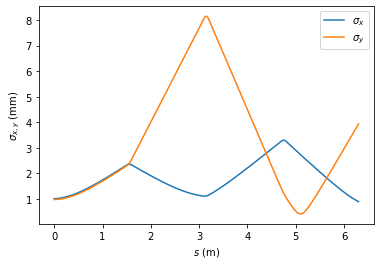

In [38]:
all_p = track_a_lattice(p_in, stubbed_lattice)
stdx = np.array([torch.std(par.x).item() for par in all_p])
stdy = np.array([torch.std(par.y).item() for par in all_p])
s = np.array([par.s.item() for par in all_p])
plt.plot(s, stdx*1000, label=r'$\sigma_x$')
plt.plot(s, stdy*1000, label=r'$\sigma_y$')
plt.xlabel(r'$s$ (m)')
plt.ylabel(r'$\sigma_{x,y}$ (mm)')
plt.legend()

# Hessian Matrix example

In [39]:
# Particle bunch with Gaussian distribution
sample_size = 1000
mean = torch.zeros(6, **tkwargs)
cov = torch.diag(torch.tensor([1e-6, 2e-6, 1e-6, 2e-6, 1e-6, 2e-6],**tkwargs))
dist = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
sample = dist.sample(torch.Size([sample_size]))
p_in = Particle(*sample.T, ts, tp0c, tmc2)

L_d = 1.00 # Drift length
L_q = 0.1 # Quad length 
drift = Drift(torch.tensor(L_d, **tkwargs))

def sigmax_end(k1s):
    """returns x beamsize after lattice composed by len(k1s)+1 
    drifts with len(k1s) quadrupoles in between.
    """
    lattice = [drift]
    
    for k1 in k1s:
        lattice.append(Quadrupole(torch.tensor(L_q, **tkwargs), k1, NUM_STEPS))
        lattice.append(drift)

    p_out = track_a_lattice(p_in, lattice)[-1]
    return torch.std(p_out.x)

#k1s = torch.tensor([10,-10,10,-10,10,-10,10,-10,10,-10], **tkwargs)
k1s = torch.zeros(10, **tkwargs)

In [40]:
%%time
hessian_py = hessian(sigmax_end,k1s)
hessian_py

CPU times: user 588 ms, sys: 182 ms, total: 770 ms
Wall time: 532 ms


tensor([[6.5237564748244913e-05, 1.9296873377563125e-04, 3.0299170657400082e-04,
         3.7971560979332351e-04, 4.2314044343359910e-04, 4.3326620749482782e-04,
         4.1009290197700961e-04, 3.5362052688014435e-04, 2.6384908220423216e-04,
         1.4077856794927307e-04],
        [1.9296873377563125e-04, 4.2725870543861819e-05, 2.9295807833054106e-04,
         5.0134617449114599e-04, 6.3868912913185626e-04, 7.0498694225267205e-04,
         7.0023961385359303e-04, 6.2444714393461974e-04, 4.7760953249575185e-04,
         2.5972677953698943e-04],
        [3.0299170657400093e-04, 2.9295807833054117e-04, 2.6621382124282305e-05,
         3.6456731419586507e-04, 6.3315124026133436e-04, 7.9297052493927851e-04,
         8.4402516822969741e-04, 7.8631517013259117e-04, 6.1984053064795958e-04,
         3.4460124977580284e-04],
        [3.7971560979332351e-04, 5.0134617449114577e-04, 3.6456731419586480e-04,
         1.5574718720285523e-05, 4.0652677682203323e-04, 6.9721695555464709e-04,
       

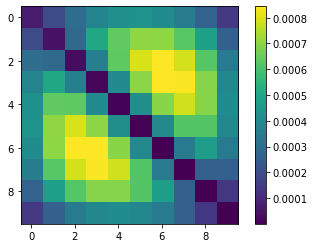

In [41]:
plt.imshow(hessian_py.detach().numpy())
plt.colorbar()

In [42]:
p_in = Particle(*sample.detach().numpy().T, 0, p0c, mc2)

L_d = 1.00 # Drift length
L_q = 0.1 # Quad length 
drift = Drift(L_d)
def sigmax_end2(k1s):
    """returns x beamsize after lattice composed by len(k1s)+1 
    drifts with len(k1s) quadrupoles in between.
    """
    lattice = [drift]
    
    for k1 in k1s:
        lattice.append(Quadrupole(L_q, k1, 1))
        lattice.append(drift)

    p_out = track_a_lattice(p_in, lattice)[-1]
    
    return np.std(p_out.x)

#k1s = np.array([10,-10,10,-10,10,-10,10,-10,10,-10])
k1s = np.zeros(10)

In [43]:
%%time
hessian_nd = nd.Hessian(sigmax_end2)(k1s)
hessian_nd

CPU times: user 38.4 s, sys: 0 ns, total: 38.4 s
Wall time: 38.4 s


array([[7.0543358684067479e-05, 2.1517143855570914e-04,
        3.3028902459338391e-04, 4.1042077606176405e-04,
        4.5556669296126343e-04, 4.6572677530080903e-04,
        4.4090102307412947e-04, 3.8108943628279178e-04,
        2.8629201492291669e-04, 1.5650875899919501e-04],
       [2.1517143855570914e-04, 5.2576872879517533e-05,
        3.2701019473031307e-04, 5.3874027829246926e-04,
        6.7775733310848228e-04, 7.4406135918296317e-04,
        7.3765235650488181e-04, 6.5853032508315901e-04,
        5.0669526491401470e-04, 2.8214717600374891e-04],
       [3.3028902459338391e-04, 3.2701019473031307e-04,
        3.9878794243936204e-05, 4.0707621069151857e-04,
        6.7726858776970690e-04, 8.3704730069392608e-04,
        8.8641234947617461e-04, 8.2536373411324791e-04,
        6.5390145460689317e-04, 3.7202551096066663e-04],
       [4.1042077606176405e-04, 5.3874027829246926e-04,
        4.0707621069151857e-04, 3.1100416883045171e-05,
        4.5410045694667395e-04, 7.44684599845

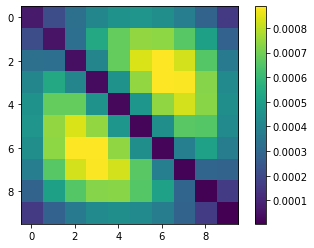

In [44]:
plt.imshow(hessian_nd)
plt.colorbar()

In [45]:
np.allclose(hessian_nd, hessian_py.detach().numpy())

False

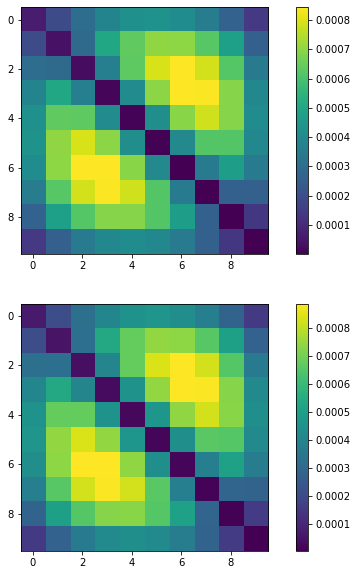

In [46]:
fig, axs = plt.subplots(2, figsize=(10,10))
cm = axs[0].imshow(hessian_py.detach().numpy())
fig.colorbar(cm,ax=axs[0])
#ax.imshow(hessian_py.detach().numpy())
#ax = axs[1]
#ax.imshow(1-hessian_nd)
cm = axs[1].imshow(hessian_nd)
fig.colorbar(cm,ax=axs[1])

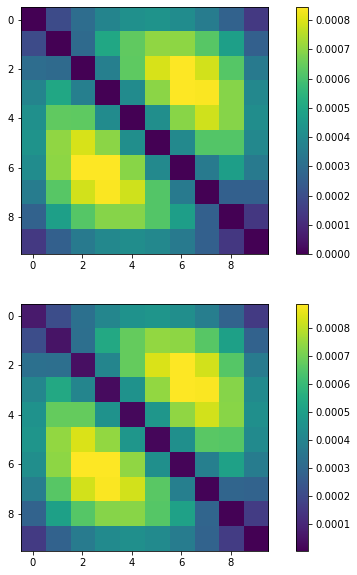

In [47]:
hessian_numpy = hessian_py.detach().numpy()
for i in range(len(hessian_nd[:,0])):
    hessian_numpy[i,i]=0
fig, axs = plt.subplots(2, figsize=(10,10))
cm = axs[0].imshow(hessian_numpy)
fig.colorbar(cm,ax=axs[0])
#ax.imshow(hessian_py.detach().numpy())
#ax = axs[1]
#ax.imshow(1-hessian_nd)
cm = axs[1].imshow(hessian_nd)
fig.colorbar(cm,ax=axs[1])

In [48]:
dif = np.abs((hessian_py.detach().numpy()-hessian_nd)/hessian_py.detach().numpy())
np.max(dif),np.min(dif)

/tmp/ipykernel_22936/3865154767.py:1: RuntimeWarning: divide by zero encountered in true_divide
  dif = np.abs((hessian_py.detach().numpy()-hessian_nd)/hessian_py.detach().numpy())


(inf, 0.04966019411029834)

# Optimization examples

In [49]:
# Initial beam distribution
sample_size = 1000
mean = torch.zeros(6, **tkwargs)
cov = torch.diag(torch.tensor([1e-6, 2e-6, 1e-6, 2e-6, 1e-6, 2e-6],**tkwargs))
dist = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
sample = dist.sample(torch.Size([sample_size]))
p_in = Particle(*sample.T, ts, tp0c, tmc2)

# Lattice fixed parameters
L_d = 1.00 # Drift length
L_q = 0.1 # Quad length 
drift = Drift(torch.tensor(L_d, **tkwargs))

In [50]:
# Objective function (O.F.)
def beamsize(k1s):
    """Returns std(sqrt(x^2+y^2)) after lattice composed by len(k1s)+1 drifts with
    len(k1s) quadrupoles in between.
    """
    lattice = [drift]
    for k1 in k1s:
        lattice.append( Quadrupole(torch.tensor(L_q, **tkwargs), k1, NUM_STEPS) )
        lattice.append( drift )
    p_out = track_a_lattice(p_in, lattice)[-1]
    return torch.std(torch.sqrt(p_out.x**2+p_out.y**2))

# Model to optimize using torch.nn.Module
class BeamSizeModel(torch.nn.Module):
    """Beam size torch module."""
    def __init__(self, k1s):
        super().__init__()
        self.register_parameter('k1s',torch.nn.Parameter(k1s))
    def forward(self):
        return beamsize(self.k1s)# +torch.norm(self....)  # O.F.

In [51]:
def train_model(model, training_iter):
    history_param = [None] * training_iter
    history_loss = [None] * training_iter
    # print the trainable parameters
    for param in model.named_parameters():
        print(f'{param[0]} : {param[1]}')
    
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Calc loss and backprop gradients
        loss = model()  # loss is just O.F.
        loss.backward()
        if i%10==0: #print each 10 steps
            print('Iter %d/%d - Loss: %.5f '% (
                i + 1, training_iter, loss.item()
            ))
        for param in model.parameters():
            history_param[i] = param.data.detach().numpy().copy()
        history_loss[i] = loss.detach().numpy().copy()
        optimizer.step()
        

    return np.asarray(history_param), np.asarray(history_loss)

In [52]:
%%time
# Initial k1s
k1s = torch.zeros(5, **tkwargs)

# Optimization
model = BeamSizeModel(k1s)
params, loss = train_model(model, 1000)

k1s : Parameter containing:
tensor([0., 0., 0., 0., 0.], dtype=torch.float64, requires_grad=True)
Iter 1/1000 - Loss: 0.00591 
Iter 11/1000 - Loss: 0.00582 
Iter 21/1000 - Loss: 0.00542 
Iter 31/1000 - Loss: 0.00457 
Iter 41/1000 - Loss: 0.00343 
Iter 51/1000 - Loss: 0.00280 
Iter 61/1000 - Loss: 0.00250 
Iter 71/1000 - Loss: 0.00210 
Iter 81/1000 - Loss: 0.00180 
Iter 91/1000 - Loss: 0.00156 
Iter 101/1000 - Loss: 0.00137 
Iter 111/1000 - Loss: 0.00123 
Iter 121/1000 - Loss: 0.00111 
Iter 131/1000 - Loss: 0.00102 
Iter 141/1000 - Loss: 0.00094 
Iter 151/1000 - Loss: 0.00088 
Iter 161/1000 - Loss: 0.00083 
Iter 171/1000 - Loss: 0.00078 
Iter 181/1000 - Loss: 0.00073 
Iter 191/1000 - Loss: 0.00069 
Iter 201/1000 - Loss: 0.00066 
Iter 211/1000 - Loss: 0.00063 
Iter 221/1000 - Loss: 0.00060 
Iter 231/1000 - Loss: 0.00058 
Iter 241/1000 - Loss: 0.00056 
Iter 251/1000 - Loss: 0.00055 
Iter 261/1000 - Loss: 0.00054 
Iter 271/1000 - Loss: 0.00054 
Iter 281/1000 - Loss: 0.00053 
Iter 291/1000 

Text(0.5, 0, 'n_iter')

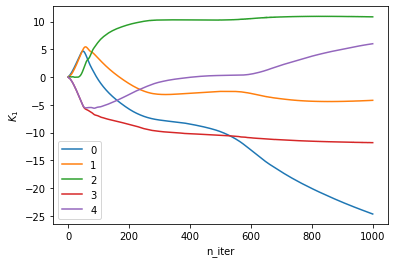

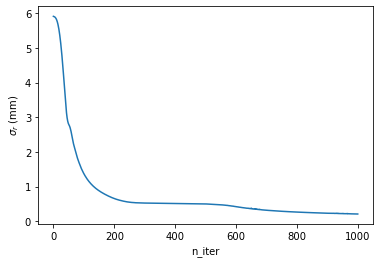

In [53]:
# Plot O.F. and parameters as function of iteration number
for i in range(len(k1s)):
    plt.plot(np.arange(len(params[:,0])), params[:,i], label=str(i))
plt.legend()
plt.ylabel(r'$K_1$')
plt.xlabel('n_iter')
plt.figure()
plt.plot(np.arange(len(loss)), loss*1000)
plt.ylabel(r'$\sigma_r$ (mm)')
plt.xlabel('n_iter')
#params, loss

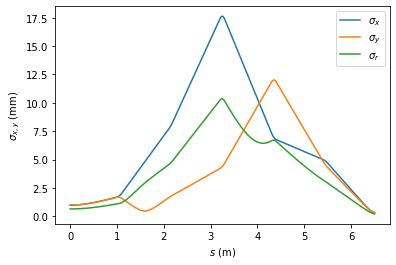

In [54]:
# plot beamsize for final config 
lattice = [drift]
k1s = torch.tensor(params[-1], **tkwargs)
for k1 in k1s:
    lattice.append( Quadrupole(torch.tensor(L_q, **tkwargs), k1, NUM_STEPS) )
    lattice.append( drift )
n=10
stubbed_lattice = stub_lattice(lattice, n)
all_p = track_a_lattice(p_in, stubbed_lattice)
stdx, stdy, stdr, s = [torch.std(par.x) for par in all_p], [torch.std(par.y) for par in all_p], [torch.std(torch.sqrt(par.x**2+par.y**2)) for par in all_p], [par.s for par in all_p]
plt.plot(s, np.array(stdx)*1000, label=r'$\sigma_x$')
plt.plot(s, np.array(stdy)*1000, label=r'$\sigma_y$')
plt.plot(s, np.array(stdr)*1000, label=r'$\sigma_r$')
plt.xlabel(r'$s$ (m)')
plt.ylabel(r'$\sigma_{x,y}$ (mm)')
plt.legend()

# misc

In [55]:
np.finfo(np.float64).eps

2.220446049250313e-16

In [56]:
torch.finfo(torch.float64).eps

2.220446049250313e-16

In [57]:
np.finfo(np.float32).eps

1.1920929e-07

In [58]:
torch.finfo(torch.float32).eps

1.1920928955078125e-07

In [59]:
# Particle bunch with Gaussian distribution
c_light = 2.99792458e8 #speed of light in m/s
m_e = 0.510998950e6 #electron mass in eV

# Incoming particle
s = 0.0 #initial s
p0c = 4.0E+07  # Reference particle momentum in eV
mc2 = 1*m_e  # electron mass in eV
ts = torch.tensor(s)
tp0c = torch.tensor(p0c)
tmc2 = torch.tensor(mc2)


sample_size = 10
mean = torch.zeros(6)
cov = torch.diag(torch.tensor([1e-6, 2e-6, 1e-6, 2e-6, 1e-6, 2e-6]))
dist = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
sample = dist.sample(torch.Size([sample_size]))
p_in = Particle(*sample.T, ts, tp0c, tmc2)

In [60]:
# define lattice
L=1.0 # Drift length in m
d1 = Drift(torch.tensor(L))
L = 0.1  # quad length in m
K1 = 12.0  # Quad focusing strength. Positive is focusing in x
NUM_STEPS = 5  # number of divisions for tracking. 1 is bmad default when there are
# no other multipoles
q1 = Quadrupole(torch.tensor(L), torch.tensor(K1), NUM_STEPS)

lattice = [d1, q1]*7

In [61]:
# do track
with torch.autograd.detect_anomaly():
    out = track_a_lattice(p_in, lattice)

/tmp/ipykernel_22936/1195989846.py:2: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


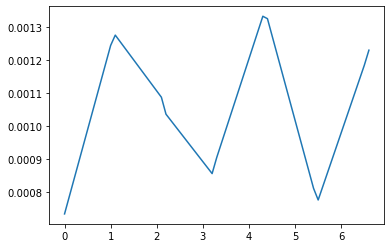

In [62]:
fig,ax = plt.subplots()
data = []
for i in range(len(out)):
    data += [[out[i].s, torch.std(out[i].x)]]
ax.plot(*torch.tensor(data).T)

In [63]:
tdata = torch.tensor(data)[:50]
tdata

tensor([[0.0000000000000000e+00, 7.3303398676216602e-04],
        [1.0000000000000000e+00, 1.2437831610441208e-03],
        [1.1000000238418579e+00, 1.2749618617817760e-03],
        [2.0999999046325684e+00, 1.0867164237424731e-03],
        [2.1999998092651367e+00, 1.0352573590353131e-03],
        [3.1999998092651367e+00, 8.5528544150292873e-04],
        [3.2999997138977051e+00, 9.0398127213120461e-04],
        [4.2999997138977051e+00, 1.3321635778993368e-03],
        [4.3999996185302734e+00, 1.3247643364593387e-03],
        [5.3999996185302734e+00, 8.1044272519648075e-04],
        [5.4999995231628418e+00, 7.7530927956104279e-04],
        [6.4999995231628418e+00, 1.1834444012492895e-03],
        [6.5999994277954102e+00, 1.2293339241296053e-03],
        [7.5999994277954102e+00,                    nan],
        [7.6999993324279785e+00,                    nan]])

In [64]:
1029037/346781323848960

2.9673945199199805e-09

In [65]:
4585922449/15605159573203200

2.938721919175267e-07